## Dotter

A simple testbed for basic reinforcement algorithm in the form of a primitive computer game.

Given below is the set-up of the game:

- The game is played in a 64 x 64 world (similar to a game board)
- There is one "mouse" character controlled by the intelligent agent
- There are pieces of cheese scattered over the board. The agent can score points by consuming them. Consuming a piece of cheese removes it from that particular position and moves it elsewhere randomly
- There are cat characters (2 of them by default) that will pursue the mouse character by making moves towards it. Cats move considerably slower than the mouse, and in theory, the mouse can always run away. A collision with the cat will cause a significant penalty.
- The mouse character can "wrap around" (i.e. go past the boundaries of the world and come out on the other end). No other object can do this.


This demo makes it possible to run the game with:
- A Proximal Policy Optimization agent
- A Deep Q Network agent

The Epsilon Decay method is used for the exploitation-exploration tradeoff (more random exploration at the beginning, gradually reducing the probability of a random action and increasing the probability of using the policy).

Other agents can be added as needed. The default implementations are provided by Tensorforce.

The state of the world is preprocessed to make learning easier. The state tensor that is supplied to the agent is composed of two matrices, one for the current state, and one for the previous, in which the rows represent the vector distance from the mouse character to each object, with the exception of the mouse character itself, whose position is recorded in absolute coordinates. The main motivation for using both the current state and the previous state is for the network to be able to learn the directions in which the different objects are moving (similar to what was used in many classic experiments with Atari games).

State matrix:
\begin{equation*}
    \left[
        \begin{array}{cc}
        \begin{bmatrix}
        x_{mouse} & y_{mouse} \\
        x_{max} - x_{mouse} & y_{max} - y_{mouse} \\
        x_{cat_1} & y_{cat_1} \\
        x_{cat_2} & y_{cat_2} \\
        x_{cheese_1} & y_{cheese_1} \\
        x_{cheese_2} & y_{cheese_2} \\
        x_{cheese_3} & y_{cheese_3} \\
        ... & ... \\
        \end{bmatrix}_{current} \\ \begin{bmatrix}
        x_{mouse} & y_{mouse} \\
        x_{max} - x_{mouse} & y_{max} - y_{mouse} \\
        x_{cat_1} & y_{cat_1} \\
        x_{cat_2} & y_{cat_2} \\
        x_{cheese_1} & y_{cheese_1} \\
        x_{cheese_2} & y_{cheese_2} \\
        x_{cheese_3} & y_{cheese_3} \\
        ... & ... \\
        \end{bmatrix}_{previous}
        \end{array}
    \right]
\end{equation*}

The values are divided by the maximum in order to improve numerical stability (previous attempts using raw coordinates have caused the agents to behave in an unstable fashion).

The demo provides:
- A way to run the game "blind" (in-memory, with no real-time output).
- A real-time visualization of the game (using Matplotlib)
- A graph of the moving average of the reward collected over a configurable number of game steps.

### References
- [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347) (John Schulman, Filip Wolski, Prafulla Dhariwal, Alec Radford, Oleg Klimov)
- [Human-Level Control through Deep Reinforcement Learning](https://www.nature.com/articles/nature14236)

In [22]:
!pip install tensorforce

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time
import ipywidgets as widgets
from ipywidgets import interact

In [24]:
class Thing:
    def __init__(self, thing_type, position):
        self.thing_type, self.position = thing_type, np.array(position)
    def __str__(self):
        return "{0}: {1}".format(self.thing_type, self.position)

In [25]:
class World:
    CHEESE_REWARD = 100
    CAT_PENALTY = -1000
    CAT_PERIOD = 5
    direction_map = {
        'up': np.array((-1, 0)),
        'down': np.array((1, 0)),
        'left': np.array((0, -1)),
        'right': np.array((0, 1))
    }
    def __init__(self, size, things=None):
        self.size = np.array(size)
        self.bounds = self.size - 1
        self.things = things or []
        self.thing_types = list(sorted(set(thing.thing_type for thing in self.things)))
        self.thing_type_map = {thing_type: idx for idx, thing_type in enumerate(self.thing_types)}
        self.things_by_type = self._get_things_by_type()
        self.step_number = 0
        self.score = 1000
        self.origin = np.array([0, 0])
        self.mouse = self.things_by_type['mouse'][0]
        self.environment = [thing for thing in things if thing.thing_type != 'mouse']
        self.state_matrix = np.zeros((2, len(self.things)+1, 2), np.float)
        
    def _get_things_by_type(self):
        type_map = {}
        for thing in self.things:
            if thing.thing_type not in type_map:
                type_map[thing.thing_type] = []
            type_map[thing.thing_type].append(thing)
        return type_map
        
    def to_world_matrix(self):
        matrix = np.zeros(self.size)
        for thing in self.things:
            matrix[tuple(thing.position)] = self.thing_type_map[thing.thing_type] + 1
        return matrix
    
    def _build_state_matrix(self):
        current_state = self.state_matrix[0]
        current_state[0] = self.mouse.position
        current_state[0] = self.size - self.mouse.position
        current_state[2:] = (
            np.array([thing.position for thing in self.environment]) 
            - self.mouse.position)
        current_state = current_state / self.size

    def _update_state_matrix(self):
        self.state_matrix[1] = self.state_matrix[0]
        self._build_state_matrix()
    
    def step(self):
        self.step_number += 1
        if self.step_number % self.CAT_PERIOD == 0:
            self._update_cats()
        self.score -= 1
        self._check_collision('cheese', self.CHEESE_REWARD)
        self._check_collision('cat', self.CAT_PENALTY)        
        self._update_state_matrix()
        
    def _update_cats(self):
        cats = self.things_by_type['cat']

        for cat in cats:
            delta = np.maximum(
                np.array((-1, -1)),
                np.minimum(
                    self.mouse.position - cat.position,
                    np.array((1, 1))
                )
            )
            self.move_object(cat, delta)

    def _check_collision(self, other_type, score_change):
        for other in self.things_by_type[other_type]:
            if np.all(other.position == self.mouse.position):
                self.score += score_change
                other.position = np.random.randint(low=0, high=np.min(self.size - 1), size=2)
                if other.thing_type == 'cat':
                    self.mouse.position = (
                        np.random.randint(low=0, high=np.min(self.size - 1), size=2))
               
    def move_object(self, obj, delta, wrap=False):
        new_position = obj.position + delta
        obj.position = self._wrap(new_position) if wrap else self._clip(new_position)


    def _clip(self, position):
        return np.maximum(
            self.origin,
            np.minimum(
                position,
                self.size - 1
            )
        )
    
    def _wrap(self, position):
        result = np.where(position < self.origin, position + self.size, position)
        result = np.where(position >= self.size, result - self.size, result)
        return result
        
    def move_mouse(self, direction):
        delta = self.direction_map[direction]
        self.move_object(self.mouse, delta, wrap=True)        

In [26]:
WORLD_SIZE = (64, 64)
min_coord = np.min(np.array(WORLD_SIZE))

In [27]:
cheese_count = 25
cat_count = 2

In [28]:
def generate_random_things(thing_type, count):
    return [Thing(thing_type, np.random.randint(low=0, high=min_coord, size=2)) for _ in range(count)]

In [29]:
things = (
    [Thing('mouse', (32, 32))] 
           + generate_random_things('cat', cat_count)
           + generate_random_things('cheese', cheese_count))
world = World(
    size=WORLD_SIZE,
    things=things)
state_shape = world.state_matrix.shape

In [30]:
exploration = dict(
    type='epsilon_decay',
    initial_epsilon=1.0,
    final_epsilon=0.20,
    timesteps=10000
)

In [31]:
from tensorforce.agents import DQNAgent

def agent_dqn():
    state_shape = world.state_matrix.shape
    network_spec = [
        dict(type='flatten'),
        dict(type='dense', size=512),
        dict(type='dense', size=256)
    ]

    agent = DQNAgent(
        states=dict(type='float', shape=state_shape),
        actions=dict(type='int', num_actions=4),
        network=network_spec,
        update_mode=dict(
            unit='timesteps',
            batch_size=1,
            frequency=1
        ),
        memory=dict(
            type='latest',
            include_next_states=True,
            capacity=100
        ),
        actions_exploration=exploration,
        target_sync_frequency=10
    )
    return agent

In [32]:
from tensorforce.agents import PPOAgent

def agent_ppo():
    agent = PPOAgent(
        states=dict(type='float', shape=state_shape),
        actions=dict(type='int', num_actions=4),
        network=[
            dict(type='flatten'),
            dict(type='dense', size=2048),
            dict(type='dense', size=1024),
            dict(type='dense', size=512),
        ],
        step_optimizer=dict(
            type='adam',
            learning_rate=1e-4
        ),
        actions_exploration=exploration,        
        batching_capacity=10
    )
    return agent

In [33]:
agents = {
    'DQN': agent_dqn,
    'PPO': agent_ppo
}
default_agent_id = 'PPO'

In [34]:
agent_params = {'agent_id': agents[default_agent_id]}

@interact(
    agent_id=widgets.Dropdown(options=agents.keys(),
                              value=default_agent_id),
                              description='Agent')
def select_agent(agent_id):
    agent_params['agent_id'] = agent_id

interactive(children=(Dropdown(description='agent_id', index=1, options=('DQN', 'PPO'), value='PPO'), Output()), _dom_classes=('widget-interact',))

In [35]:
reward_history = []
agent = agents[agent_params['agent_id']]()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [36]:
%matplotlib notebook
actions = ['up', 'down', 'left', 'right']

def data_gen():
    previous_score = world.score
    while True:
        action_idx = agent.act(world.state_matrix)
        action = actions[action_idx]
        world.move_mouse(action)
        world.step()
        reward = world.score - previous_score
        reward_history.append(reward)
        agent.observe(reward=reward, terminal=False)
        previous_score = world.score    
        yield reward, world.to_world_matrix()

In [37]:
import ipywidgets as widgets
from itertools import islice
from IPython.display import display
from datetime import timedelta
import time

progress_step = 100
progress_bar = widgets.IntProgress(min=0, max=100, description='Progress')
hours_slider = widgets.IntText(min=1, max=100000, value=0, description='Hours')
minutes_slider = widgets.IntText(min=1, max=60, value=0, description='Minutes')
seconds_slider = widgets.IntText(min=1, max=60, value=5, description='Seconds')

    
def run_blind(*args):
    delta = timedelta(hours=hours_slider.value, minutes=minutes_slider.value, seconds=seconds_slider.value)
    total_seconds = delta.total_seconds()
    start_seconds = time.clock()
    progress_bar.max = total_seconds
    progress_bar.value = 0
    for idx, step in enumerate(data_gen()):
        if idx % progress_step == 0:
            running_time = time.clock() - start_seconds
            if running_time > total_seconds:
                break
            progress_bar.value = running_time
    progress_bar.value = progress_bar.max

run_blind_button = widgets.Button(description='Run Blind')
run_blind_button.on_click(run_blind)

display(widgets.HBox([hours_slider, minutes_slider, seconds_slider, run_blind_button]))
display(progress_bar)

HBox(children=(IntText(value=0, description='Hours'), IntText(value=0, description='Minutes'), IntText(value=5, description='Seconds'), Button(description='Run Blind', style=ButtonStyle())))

IntProgress(value=0, description='Progress')

<IPython.core.display.Javascript object>


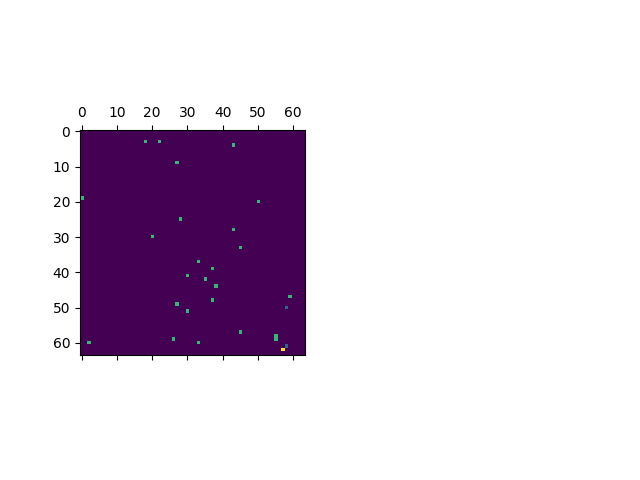

In [38]:
from  matplotlib.animation import FuncAnimation
fig = plt.figure()

world_ax = fig.add_subplot(1, 2, 1)
world_plot = world_ax.matshow(world.to_world_matrix())

def update(data):
    reward, world_matrix = data
    try:
        world_plot.set_data(world_matrix)    
        return [world_plot]
    except Exception as e:
        print(f"Error: {e}")
        
FuncAnimation(fig, update, data_gen, interval=1)

In [39]:
import pandas as pd
reward_history_df = pd.DataFrame({'reward': reward_history})
@interact(
    granularity=widgets.IntSlider(value=3000, min=0, max=10000),
    steps=widgets.IntSlider(value=10000, min=100, max=len(reward_history_df)),
    continuous_update=False)
def plot_reward(granularity, steps):    
    reward_history_rolling_df = reward_history_df.iloc[-steps:].rolling(granularity)
    reward_history_rolling_df.mean().plot()

interactive(children=(IntSlider(value=3000, description='granularity', max=10000), IntSlider(value=10000, description='steps', max=23647, min=100), Output()), _dom_classes=('widget-interact',))